In [14]:
import cv2
import numpy as np
import pytesseract
import matplotlib.pyplot as plt

# ścieżka do pliku exe OCR, ten cały tesseract musi być zainstalowany wcześniej 
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\wilko\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'

class SudokuBoard():
    def __init__(self, n, image):
        self.board_image = image
        self.n = n

        self.BOARD_WIDTH = 2 * image.shape[1]
        self.BOARD_HEIGHT = 2 * image.shape[0]
        
        if n == 3:
            self.cell_size = self.BOARD_HEIGHT // 9
        elif n == 2:
            self.cell_size = self.BOARD_HEIGHT // 4

        self.cell_images = []

        self.process_board_image()
        self.split_board_image()

    def process_board_image(self):
        ''' Zwiększa rozdzielczość screena planszy, usuwa niepotrzebne linie w planszy i konwertuje do obrazu binarnego '''

        resized_board_img = cv2.resize(self.board_image, (self.BOARD_WIDTH, self.BOARD_HEIGHT)) 
        gray_board_img = cv2.cvtColor(resized_board_img, cv2.COLOR_RGB2GRAY)
        _,binary_board_img = cv2.threshold(gray_board_img, 127,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        if self.n == 3:
            line_coord_x = self.BOARD_WIDTH // 3
            line_coord_y = self.BOARD_HEIGHT // 3

            cv2.line(binary_board_img, (0,line_coord_y), (self.BOARD_WIDTH, line_coord_y), (255,255,255), 20)
            cv2.line(binary_board_img, (0,line_coord_y*2),(self.BOARD_WIDTH, line_coord_y*2),(255,255,255), 20)

            cv2.line(binary_board_img, (line_coord_x,0), (line_coord_x, self.BOARD_HEIGHT), (255,255,255), 20)
            cv2.line(binary_board_img, (line_coord_x*2,0), (line_coord_x*2, self.BOARD_HEIGHT), (255,255,255), 20)
        
        elif self.n == 2:
            line_coord_x = self.BOARD_WIDTH // 2
            line_coord_y = self.BOARD_HEIGHT // 2

            cv2.line(binary_board_img, (0,line_coord_y), (self.BOARD_WIDTH, line_coord_y), (255,255,255), 20)
            cv2.line(binary_board_img, (line_coord_x,0), (line_coord_x, self.BOARD_HEIGHT), (255,255,255), 20)


        self.processed_board_image = binary_board_img
    
    def split_board_image(self):
        ''' Dzieli plansze na 81 pól tak żeby OCR na każdym był w stanie wykryć cyfrę '''

        y_start = 0
        x_start = 0
        if self.n == 3:
            y_end = self.BOARD_HEIGHT // 9
            x_end = self.BOARD_WIDTH // 9

        elif self.n == 2:
            y_end = self.BOARD_HEIGHT // 4
            x_end = self.BOARD_WIDTH // 4

        for i in range(1, self.n * self.n + 1):
            for j in range(1,self.n * self.n + 1):
                self.cell_images.append(self.processed_board_image[y_start : y_end, x_start : x_end])
                x_start += self.cell_size
                x_end += self.cell_size
            
            x_start = 0
            x_end = self.cell_size

            y_start += self.cell_size
            y_end += self.cell_size
    
    def create_board(self):
        ''' OCR wykrywa cyfry z poszczególnych komórek planszy, w pustych polach wstawione są 0, funkcja zwraca macierz numpy 9x9,'''
        
        board = []

        for image in self.cell_images:
            ocr_result = pytesseract.image_to_string(image, config='--psm 13 --oem 3 -c tessedit_char_whitelist=123456789')
            if ocr_result != '':
                board.append(int(ocr_result))
            else: 
                board.append(0)

        board = np.array(board)

        if self.n == 3:
            board = board.reshape((9,9))

        elif self.n == 2:
            board = board.reshape((4,4))

        return board

In [3]:
board_img = cv2.imread(r"C:\Users\wilko\Desktop\Studia\Projekty studia\Optymalizacja dyskretna - Sudoku\Dane\Pierdoly\ocr_test.PNG")

In [12]:
sudoku_board = SudokuBoard(3, board_img)

In [16]:
sudoku_board.cell_images[0]

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255]], dtype=uint8)

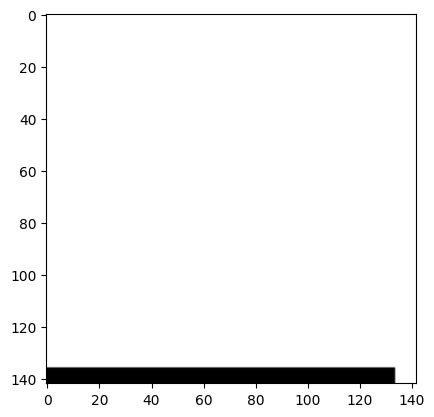

In [32]:
plt.imshow(sudoku_board.cell_images[77], cmap='gray')